In [39]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import math


class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        #x = torch.nn.functional.log_softmax(self.fc2(x), 1)
        x = self.fc2(x)
        return x
    
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, device):
        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr = learning_rate)
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = torch.nn.functional.softmax(self.policy_net(state),dim=1)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    '''def update(self, states, actions, rewards):
        self.optimizer.zero_grad()
        g = 0
        for i in reversed(range(len(rewards))):
            state = torch.tensor(states[i],dtype=torch.float).view(1,-1).to(self.device)
            action = torch.tensor(actions[i]).view(1,-1).to(self.device)
            reward = rewards[i]
            #output = self.policy_net(state)
            output = torch.nn.functional.log_softmax(self.policy_net(state),dim=1)            
            log_prob = output.gather(1, action)
            g = g * self.gamma + reward
            loss = log_prob * (-g * math.pow(self.gamma, i))
            loss.backward()
        self.optimizer.step()'''
    
    def update(self, states, actions, rewards):
        count = len(rewards)
        ngs = torch.zeros(count)
        g = 0
        for i in reversed(range(count)):
            g = g * self.gamma + rewards[i]
            ngs[i] = -g 

        states = torch.tensor(states, dtype=torch.float).to(self.device)
        actions = torch.tensor(actions).view(count, -1).to(self.device)
        ngs = ngs.view(count, -1).to(device)
        
        outputs = torch.nn.functional.log_softmax(self.policy_net(states),dim=1)
        #print(outputs.shape, actions.shape, ngs.shape)
        #loss = torch.sum(torch.log(outputs.gather(1, actions)) * ngs)
        loss = torch.sum(outputs.gather(1, actions) * ngs)
        #loss = (torch.nn.functional.cross_entropy(outputs.gather(1, actions), actions.to(torch.float))*ngs).sum()
        #loss = torch.nn.functional.cross_entropy(outputs, actions) * ngs
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


learning_rate = 1e-3
hidden_dim = 128
gamma = 0.98
device = torch.device("cpu") #torch.device("cuda") if torch.cuda.is_available () else torch.device("cpu")
env_name = "CartPole-v0"

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
env.close()

def reset_seed():
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)

def train(agent, num_episodes):
    reset_seed()
    reward_stat = np.zeros(num_episodes)
    env = gym.make(env_name)
    for episode in range(num_episodes):
        state, info = env.reset(seed=0)
        total_reward = 0
        states=[]
        actions=[]
        rewards=[]
        while True:
            action = agent.take_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state
            total_reward += reward
            if terminated or truncated:
                break
        agent.update(states,actions,rewards)
        if episode*10 % num_episodes == 0:
            print("episode:", episode, "total_reward:",total_reward)
        reward_stat[episode] = total_reward
    env.close()
    return reward_stat

def test(agent, num_episodes):
    env = gym.make(env_name,render_mode="human")
    for episode in range(num_episodes):
        state, info = env.reset()
        total_reward = 0
        while True:
            action = agent.take_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            state = next_state
            total_reward += reward
            if terminated or truncated:
                break
        #print("episode:", episode, "total_reward:",total_reward)
    env.close()


def moving_average(nums, n):
    beta = 1 - 1.0/n
    alpha = 1.0 - beta
    avg = nums[0]
    res = np.zeros_like(nums)
    for n in range(len(nums)):
        avg = avg * beta + nums[n]*alpha
        res[n] = avg
    return res

episode: 0 total_reward: 12.0
episode: 80 total_reward: 38.0
episode: 160 total_reward: 42.0
episode: 240 total_reward: 24.0
episode: 320 total_reward: 79.0
episode: 400 total_reward: 122.0
episode: 480 total_reward: 101.0
episode: 560 total_reward: 149.0
episode: 640 total_reward: 181.0
episode: 720 total_reward: 194.0


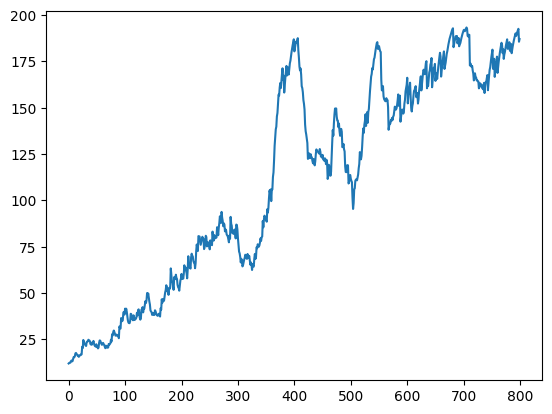

In [40]:
num_episodes = 800
reset_seed()
agent1 = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma, device)
reward_stat1  = train(agent1, num_episodes)
plt.plot(range(len(reward_stat1)), moving_average(reward_stat1,10))
plt.show()
